In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tpot import TPOTRegressor
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from featuresv2 import targets, metadata
from position_group_features import features
import json
import requests
%matplotlib inline

## Version 3 Model

In [30]:
data = pd.read_csv('outputs/model_training_data.csv')

In [82]:
data2023 = data[data['round.year'] != 2023]

In [6]:
round_matchups = [
    ('Sydney Swans','Melbourne'),
    ('Brisbane Lions','Carlton'),
    ('Gold Coast Suns','Richmond'),
    ('GWS Giants','Collingwood')]

In [7]:
round1 = [('Carlton', 'Richmond'),
('Collingwood','Sydney Swans'),
('Essendon','Hawthorn'),
('GWS Giants','North Melbourne'),
('Geelong Cats','St Kilda'),
('Gold Coast Suns','Adelaide Crows'),
('Melbourne','Western Bulldogs'),
('Port Adelaide','West Coast Eagles'),
('Fremantle','Brisbane Lions')]

In [9]:
def generate_test_train_split(data, features, target, test_size=0.3):
    X = data[features]
    y = data[target]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return {"x_train":x_train,"x_test":x_test,"y_train":y_train,"y_test":y_test}

In [10]:
def tpot_pipeline(data, features, target, size=20, scoring='r2'):
    data_ = generate_test_train_split(data, features, target)

    my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    pipeline_optimizer = TPOTRegressor(generations=5, population_size=size, verbosity=2, scoring=scoring)

    pipeline_optimizer.fit(data_['x_train'], data_['y_train'])
    
    print(pipeline_optimizer.score(data_['x_test'], data_['y_test']))
    
    return pipeline_optimizer

In [11]:
def return_stats_input(data, home_team, away_team, model_inputs, games=5):
    '''Take in player_stats and returns aggregated team stats for previous home/away team matchups'''
    
#     if 'team.name' not in model_inputs:
#         model_inputs.append('team.name')
        
    match_ups = data[(data['match.homeTeam.name']==home_team) & (data['match.awayTeam.name']==away_team)]
    weights = range(1,len(match_ups)+1)

    stats = match_ups[model_inputs+['match.homeTeam.name']].groupby('match.homeTeam.name').apply(lambda x: np.average(x, weights=weights, axis=0))
    
    return pd.DataFrame(dict(zip(model_inputs,stats[0])),index=[0])

In [12]:
def generate_margin_tear_off(model, round_matchups, team_stats, model_inputs):
    print('-------------------' + str(model.fitted_pipeline_[0]).replace('()','') + ' TEAR-OFF-------------------')
    for tup in round_matchups:
        predict = model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
        if predict < 0:
            winner = tup[1]
        else:
            winner = tup[0]
        print("------------------------------------------------")
        print("Home: " + tup[0])
        print("Away: " + tup[1])
        print("Winner: " + winner + "\t       " + "Margin: " + str(abs(round(predict))))

In [36]:
def generate_score_tear_off(home_model, away_model, round_matchups, team_stats, model_inputs):
   # print('-------------------' + str(model.fitted_pipeline_[0]).replace('()','') + ' TEAR-OFF-------------------')
    preds = []
    for tup in round_matchups:
        try:
            h_predict = home_model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
            a_predict = away_model.predict(return_stats_input(team_stats, tup[0], tup[1], model_inputs))[0]
            if h_predict < a_predict:
                winner = tup[1]
                margin = round(a_predict) - round(h_predict)
            else:
                winner = tup[0]
                margin = round(h_predict) - round(a_predict)
            paddingh = 25 - len("Home: " + tup[0])
            paddinga = 25 - len("Away: " + tup[1])
            print("------------------------------------------------")
            print("Home: " + tup[0] + " "*paddingh + str(abs(round(h_predict))))
            print("Away: " + tup[1] + " "*paddinga + str(abs(round(a_predict))))
            print("Winner: " + winner + " by "+ str(margin) + " points")
            print("Total Score: " + str(round(h_predict) + round(a_predict)))
            preds.append((h_predict, a_predict, margin))
        except:
            print("No prior game")
            preds.append((0, 0, 0))
    return preds

In [96]:
home_model = tpot_pipeline(data2023, features, targets[0], size=10)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7623210323717962

Generation 2 - Current best internal CV score: 0.8304219393259633

Generation 3 - Current best internal CV score: 0.8304219393259633

Generation 4 - Current best internal CV score: 0.8304219393259633

Generation 5 - Current best internal CV score: 0.8304219393259633

Best pipeline: ElasticNetCV(StandardScaler(input_matrix), l1_ratio=0.9500000000000001, tol=0.001)
0.8754297065732669


In [97]:
away_model = tpot_pipeline(data2023, features, targets[1], size=10)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.743949500087806

Generation 2 - Current best internal CV score: 0.743949500087806

Generation 3 - Current best internal CV score: 0.743949500087806

Generation 4 - Current best internal CV score: 0.743949500087806

Generation 5 - Current best internal CV score: 0.8051282260142264

Best pipeline: ElasticNetCV(StandardScaler(input_matrix), l1_ratio=0.30000000000000004, tol=0.001)
0.8272459757033521


In [19]:
# margin_model = tpot_pipeline(data, features, targets[2], size=10)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9731446552014216

Generation 2 - Current best internal CV score: 0.9731446552014216

Generation 3 - Current best internal CV score: 0.9731446552014216

Generation 4 - Current best internal CV score: 0.9733778941243735

Generation 5 - Current best internal CV score: 0.9733778941243735

Best pipeline: ElasticNetCV(RobustScaler(input_matrix), l1_ratio=1.0, tol=0.0001)
0.9720120903463568


In [18]:
generate_score_tear_off(home_model, away_model, round1, data, features)

------------------------------------------------
Home: Carlton            89
Away: Richmond           83
Winner: Carlton by 6 points
Total Score: 172
------------------------------------------------
Home: Collingwood        66
Away: Sydney Swans       47
Winner: Collingwood by 19 points
Total Score: 113
------------------------------------------------
Home: Essendon           102
Away: Hawthorn           83
Winner: Essendon by 19 points
Total Score: 185
------------------------------------------------
Home: GWS Giants         60
Away: North Melbourne    81
Winner: North Melbourne by 21 points
Total Score: 141
------------------------------------------------
Home: Geelong Cats       104
Away: St Kilda           63
Winner: Geelong Cats by 41 points
Total Score: 167
------------------------------------------------
Home: Gold Coast Suns    96
Away: Adelaide Crows     77
Winner: Gold Coast Suns by 19 points
Total Score: 173
------------------------------------------------
Home: Melbourne   

[(88.99739369187981, 82.65395998844423, 6),
 (66.48971220167981, 46.69217192558813, 19),
 (102.24136632348922, 82.65298244086301, 19),
 (60.02225023019412, 81.02904656379373, 21),
 (104.19426104838793, 63.01240603446088, 41),
 (96.28345799108719, 76.89902282111923, 19),
 (112.61565911258671, 70.6647347131949, 42),
 (107.60027646074188, 52.61369998873249, 55),
 (77.46486063424743, 87.36834808496185, 10)]

In [183]:
# print(return_stats_inputv3(data, home_team, away_team, features))
# generate_margin_tear_off(margin_model, round1, data, features)
# data[(data['match.homeTeam.name']==home_team) & (data['match.awayTeam.name']==away_team)][features].head()

In [72]:
fix_data_2024 = json.loads(requests.get('https://fixturedownload.com/feed/json/afl-2024').content)

fix_data_2023 = json.loads(requests.get('https://fixturedownload.com/feed/json/afl-2023').content)

fixtures2024 = pd.DataFrame(fix_data_2024)
games2024 = list(zip(fixtures2024.HomeTeam, fixtures2024.AwayTeam))

fixtures2023 = pd.DataFrame(fix_data_2023)
games2023 = list(zip(fixtures2023.HomeTeam, fixtures2023.AwayTeam))

predicted_season = generate_score_tear_off(home_model, away_model, games2023, data2023, features)

fixtures2023['predicted_home'] = [round(i[0]) for i in predicted_season]
fixtures2023['predicted_away'] = [round(i[1]) for i in predicted_season]

pred_winner = []
winner = []
for i, row in fixtures2023.iterrows():

    if row[7] > row[8]:
        winner.append(row[4])
    elif row[8] > row[7]:
        winner.append(row[5])
    else:
        winner.append('Draw')


    if row[9] > row[10]:
        pred_winner.append(row[4])
    elif row[10] > row[9]:
        pred_winner.append(row[5])
    else:
        pred_winner.append('Draw')

fixtures2023['predicted_winner'] = pred_winner
fixtures2023['winner'] = winner
fixtures2023['predicted_margin'] = fixtures2023['predicted_home'] - fixtures2023['predicted_away']
fixtures2023['actual_margin'] = fixtures2023['HomeTeamScore'] - fixtures2023['AwayTeamScore']
fixtures2023['correct'] = [1 if row[11]==row[12] else 0 for i,row in fixtures2023.iterrows()]
fixtures2023['bet'] = ["1-39" if abs(row[13]) < 40 else "40+" for i,row in fixtures2023.iterrows()]


fixtures2023.to_csv('outputs/predictions_and_results_2023.csv', index=False)

backtest_data = pd.read_csv('outputs/predictions_and_results_2023.csv')
backtest_data.head()

In [179]:
profit_curve_no_geelong = []
bankroll = 100
stake = 0
profit = 0
for i, row in backtest_data.iterrows():
    
    if backtest_data['predicted_winner'][i] != 'Geelong Cats':
        stake = -1 * 0.1 * bankroll
        profit = -stake * backtest_data['odds'][i] * backtest_data['win'][i]
        
        bankroll+=stake+profit

        profit_curve_no_geelong.append(bankroll)
    else:
        bankroll+=0

        profit_curve_no_geelong.append(bankroll)

In [180]:
profit_curve = []
bankroll = 100
stake = 0
profit = 0
for i, row in backtest_data.iterrows():
    
    stake = -1 * 0.1 * bankroll
    profit = -stake * backtest_data['odds'][i] * backtest_data['win'][i]

    bankroll+=stake+profit

    profit_curve.append(bankroll)

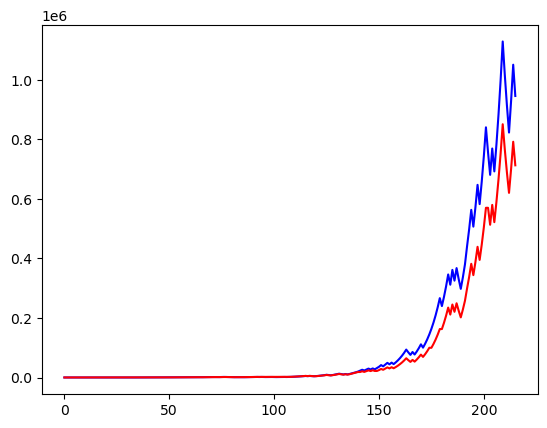

In [181]:
plt.plot(profit_curve, color='b')
plt.plot(profit_curve_no_geelong, color='r')